## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [20]:
pip install --upgrade --force-reinstall numpy

  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.


  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


scipy 1.11.4 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.0.2 which is incompatible.
pygwalker 0.4.9.4 requires numpy<2.0.0, but you have numpy 2.0.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 2.0.2 which is incompatible.


In [3]:
pip install "pybind11>=2.12"

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install pylab

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pylab (from versions: none)
ERROR: No matching distribution found for pylab


In [4]:
pip install --upgrade numpy matplotlib pandas scipy scikit-learn

  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully un

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
pygwalker 0.4.9.4 requires numpy<2.0.0, but you have numpy 2.0.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 2.0.2 which is incompatible.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

# %matplotlib inline

In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

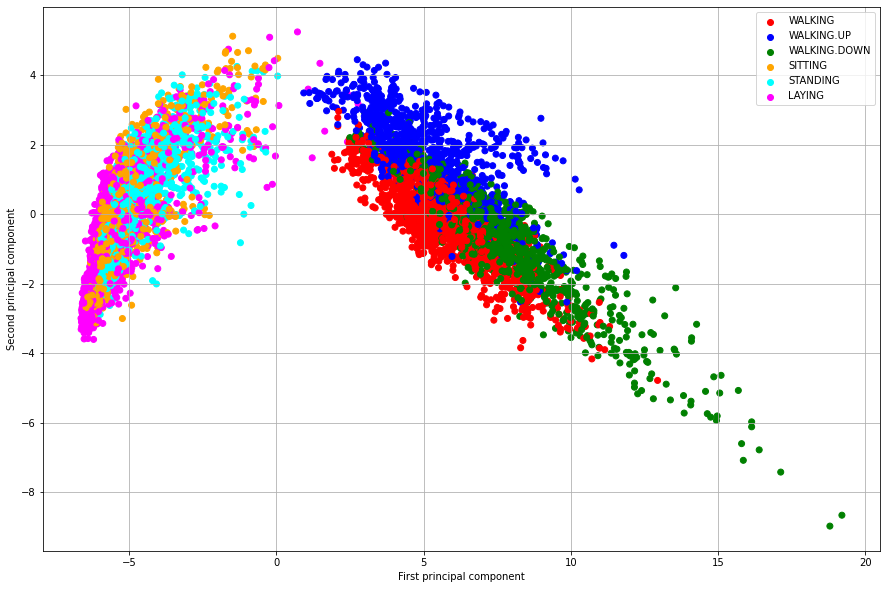

In [6]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [7]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [8]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Data Preparation
def prepare_data(X, y):
    # Reshape input data for LSTM: [samples, timesteps, features]
    X_reshaped = X.reshape((X.shape[0], X.shape[1], X.shape[2]))
    
    # One-hot encode labels
    y_encoded = to_categorical(y.flatten())
    
    return X_reshaped, y_encoded

# Build LSTM Model
def build_lstm_model(input_shape, n_classes):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

# Train and Evaluate
X_train_prepared, y_train_prepared = prepare_data(X_train, y_train)
X_test_prepared, y_test_prepared = prepare_data(X_test, y_test)

input_shape = (n_steps, n_input)
model = build_lstm_model(input_shape, n_classes)

history = model.fit(
    X_train_prepared, y_train_prepared, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test_prepared)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_prepared, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Optional: Predict probabilities for each class
predictions = model.predict(X_test_prepared)
for i, probabilities in enumerate(predictions):
    print(f"Test Sample {i}: Predicted class probabilities")
    for j, prob in enumerate(probabilities):
        print(f"{LABELS[j]}: {prob:.4f}")


C:\Users\timur\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.4206 - loss: 1.3972 - val_accuracy: 0.6016 - val_loss: 0.9604
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.6058 - loss: 0.9021 - val_accuracy: 0.6479 - val_loss: 0.8593
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.6157 - loss: 0.9219 - val_accuracy: 0.7009 - val_loss: 0.7686
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.7661 - loss: 0.5997 - val_accuracy: 0.7410 - val_loss: 0.6804
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.8148 - loss: 0.4806 - val_accuracy: 0.7254 - val_loss: 0.8909
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.8220 - loss: 0.4972 - val_accuracy: 0.8430 - val_loss: 0.5485
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9071 - loss: 0.2926 - val_accuracy: 0.8763 - val_loss: 0.4498
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9331 - loss: 0.2254 - 

184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9582 - loss: 0.0937 - val_accuracy: 0.8838 - val_loss: 0.5046
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Test Accuracy: 89.62%
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Test Sample 0: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0006
STANDING: 0.9994
LAYING: 0.0000
Test Sample 1: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0004
STANDING: 0.9995
LAYING: 0.0000
Test Sample 2: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0004
STANDING: 0.9995
LAYING: 0.0000
Test Sample 3: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0004
STANDING: 0.9995
LAYING: 0.0000
Test Sample 4: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0004
STANDI

SITTING: 0.0003
STANDING: 0.9997
LAYING: 0.0000
Test Sample 173: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0003
STANDING: 0.9997
LAYING: 0.0000
Test Sample 174: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0003
STANDING: 0.9997
LAYING: 0.0000
Test Sample 175: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0003
STANDING: 0.9997
LAYING: 0.0000
Test Sample 176: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0003
STANDING: 0.9997
LAYING: 0.0000
Test Sample 177: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0003
STANDING: 0.9997
LAYING: 0.0000
Test Sample 178: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0003
STANDI

WALKING_UPSTAIRS: 0.9966
WALKING_DOWNSTAIRS: 0.0003
SITTING: 0.0000
STANDING: 0.0006
LAYING: 0.0000
Test Sample 252: Predicted class probabilities
WALKING: 0.1356
WALKING_UPSTAIRS: 0.8514
WALKING_DOWNSTAIRS: 0.0023
SITTING: 0.0001
STANDING: 0.0105
LAYING: 0.0001
Test Sample 253: Predicted class probabilities
WALKING: 0.0307
WALKING_UPSTAIRS: 0.9623
WALKING_DOWNSTAIRS: 0.0021
SITTING: 0.0001
STANDING: 0.0047
LAYING: 0.0001
Test Sample 254: Predicted class probabilities
WALKING: 0.0007
WALKING_UPSTAIRS: 0.9990
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.0000
STANDING: 0.0002
LAYING: 0.0000
Test Sample 255: Predicted class probabilities
WALKING: 0.0193
WALKING_UPSTAIRS: 0.9657
WALKING_DOWNSTAIRS: 0.0004
SITTING: 0.0000
STANDING: 0.0145
LAYING: 0.0000
Test Sample 256: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 1.0000
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 257: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.00

WALKING_UPSTAIRS: 0.0008
WALKING_DOWNSTAIRS: 0.0005
SITTING: 0.1210
STANDING: 0.8733
LAYING: 0.0037
Test Sample 303: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0204
STANDING: 0.9794
LAYING: 0.0000
Test Sample 304: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.3434
STANDING: 0.6560
LAYING: 0.0002
Test Sample 305: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.5718
STANDING: 0.4275
LAYING: 0.0002
Test Sample 306: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0002
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.2903
STANDING: 0.7090
LAYING: 0.0003
Test Sample 307: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0002
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.4360
STANDING: 0.5632
LAYING: 0.0003
Test Sample 308: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.00

WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9923
STANDING: 0.0075
LAYING: 0.0001
Test Sample 501: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9932
STANDING: 0.0066
LAYING: 0.0001
Test Sample 502: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9919
STANDING: 0.0079
LAYING: 0.0001
Test Sample 503: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9910
STANDING: 0.0088
LAYING: 0.0001
Test Sample 504: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9925
STANDING: 0.0073
LAYING: 0.0001
Test Sample 505: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9917
STANDING: 0.0081
LAYING: 0.0001
Test Sample 506: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.00

WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.7937
STANDING: 0.2058
LAYING: 0.0002
Test Sample 644: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.8107
STANDING: 0.1888
LAYING: 0.0002
Test Sample 645: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.7960
STANDING: 0.2035
LAYING: 0.0002
Test Sample 646: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.7941
STANDING: 0.2054
LAYING: 0.0002
Test Sample 647: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.7807
STANDING: 0.2188
LAYING: 0.0002
Test Sample 648: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.7925
STANDING: 0.2070
LAYING: 0.0002
Test Sample 649: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.00

STANDING: 0.0001
LAYING: 0.0000
Test Sample 729: Predicted class probabilities
WALKING: 0.0306
WALKING_UPSTAIRS: 0.9496
WALKING_DOWNSTAIRS: 0.0189
SITTING: 0.0000
STANDING: 0.0005
LAYING: 0.0003
Test Sample 730: Predicted class probabilities
WALKING: 0.0089
WALKING_UPSTAIRS: 0.0927
WALKING_DOWNSTAIRS: 0.8970
SITTING: 0.0002
STANDING: 0.0003
LAYING: 0.0009
Test Sample 731: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0002
WALKING_DOWNSTAIRS: 0.9997
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 732: Predicted class probabilities
WALKING: 0.0273
WALKING_UPSTAIRS: 0.5294
WALKING_DOWNSTAIRS: 0.4421
SITTING: 0.0000
STANDING: 0.0009
LAYING: 0.0002
Test Sample 733: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 734: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYIN

STANDING: 0.0016
LAYING: 0.0128
Test Sample 861: Predicted class probabilities
WALKING: 0.0039
WALKING_UPSTAIRS: 0.0077
WALKING_DOWNSTAIRS: 0.9808
SITTING: 0.0017
STANDING: 0.0001
LAYING: 0.0058
Test Sample 862: Predicted class probabilities
WALKING: 0.9935
WALKING_UPSTAIRS: 0.0041
WALKING_DOWNSTAIRS: 0.0021
SITTING: 0.0001
STANDING: 0.0001
LAYING: 0.0000
Test Sample 863: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 864: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 865: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 866: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYIN

Test Sample 972: Predicted class probabilities
WALKING: 0.1336
WALKING_UPSTAIRS: 0.8318
WALKING_DOWNSTAIRS: 0.0123
SITTING: 0.0036
STANDING: 0.0115
LAYING: 0.0072
Test Sample 973: Predicted class probabilities
WALKING: 0.1135
WALKING_UPSTAIRS: 0.8544
WALKING_DOWNSTAIRS: 0.0113
SITTING: 0.0032
STANDING: 0.0107
LAYING: 0.0068
Test Sample 974: Predicted class probabilities
WALKING: 0.0961
WALKING_UPSTAIRS: 0.8748
WALKING_DOWNSTAIRS: 0.0104
SITTING: 0.0028
STANDING: 0.0099
LAYING: 0.0061
Test Sample 975: Predicted class probabilities
WALKING: 0.1184
WALKING_UPSTAIRS: 0.8492
WALKING_DOWNSTAIRS: 0.0117
SITTING: 0.0032
STANDING: 0.0108
LAYING: 0.0067
Test Sample 976: Predicted class probabilities
WALKING: 0.1242
WALKING_UPSTAIRS: 0.8428
WALKING_DOWNSTAIRS: 0.0122
SITTING: 0.0033
STANDING: 0.0107
LAYING: 0.0068
Test Sample 977: Predicted class probabilities
WALKING: 0.1283
WALKING_UPSTAIRS: 0.8382
WALKING_DOWNSTAIRS: 0.0123
SITTING: 0.0034
STANDING: 0.0109
LAYING: 0.0069
Test Sample 978: Predi

Test Sample 1054: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.9135
STANDING: 0.0861
LAYING: 0.0002
Test Sample 1055: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.8985
STANDING: 0.1011
LAYING: 0.0002
Test Sample 1056: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.8927
STANDING: 0.1069
LAYING: 0.0002
Test Sample 1057: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.8849
STANDING: 0.1146
LAYING: 0.0002
Test Sample 1058: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.9101
STANDING: 0.0895
LAYING: 0.0002
Test Sample 1059: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.9737
STANDING: 0.0260
LAYING: 0.0002
Test Sample 1060

WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 1162: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 1163: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 1164: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 1165: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 1166: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 1167: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS

Test Sample 1247: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.6955
STANDING: 0.3039
LAYING: 0.0002
Test Sample 1248: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.7185
STANDING: 0.2809
LAYING: 0.0002
Test Sample 1249: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.7389
STANDING: 0.2606
LAYING: 0.0002
Test Sample 1250: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.7494
STANDING: 0.2500
LAYING: 0.0002
Test Sample 1251: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.8602
STANDING: 0.1393
LAYING: 0.0002
Test Sample 1252: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.6393
STANDING: 0.3601
LAYING: 0.0002
Test Sample 1253

LAYING: 0.0000
Test Sample 1376: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0019
STANDING: 0.9980
LAYING: 0.0000
Test Sample 1377: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0011
STANDING: 0.9988
LAYING: 0.0000
Test Sample 1378: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0007
STANDING: 0.9993
LAYING: 0.0000
Test Sample 1379: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0005
STANDING: 0.9995
LAYING: 0.0000
Test Sample 1380: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0004
STANDING: 0.9995
LAYING: 0.0000
Test Sample 1381: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0005
STANDING: 0.9995
LAYING: 0.0000
T

SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1430: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1431: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1432: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1433: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1434: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1435: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001


STANDING: 0.0000
LAYING: 0.9999
Test Sample 1601: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1602: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1603: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1604: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0000
STANDING: 0.0000
LAYING: 1.0000
Test Sample 1605: Predicted class probabilities
WALKING: 0.9991
WALKING_UPSTAIRS: 0.0007
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.0000
STANDING: 0.0001
LAYING: 0.0000
Test Sample 1606: Predicted class probabilities
WALKING: 0.9994
WALKING_UPSTAIRS: 0.0004
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.0000
STANDING: 0.0001

Test Sample 1692: Predicted class probabilities
WALKING: 0.2753
WALKING_UPSTAIRS: 0.6620
WALKING_DOWNSTAIRS: 0.0155
SITTING: 0.0040
STANDING: 0.0408
LAYING: 0.0024
Test Sample 1693: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0004
STANDING: 0.9995
LAYING: 0.0000
Test Sample 1694: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0006
STANDING: 0.9994
LAYING: 0.0000
Test Sample 1695: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0010
STANDING: 0.9989
LAYING: 0.0000
Test Sample 1696: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0006
STANDING: 0.9993
LAYING: 0.0000
Test Sample 1697: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0010
STANDING: 0.9989
LAYING: 0.0000
Test Sample 1698

WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1762: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1763: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1764: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1765: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1766: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0001
STANDING: 0.0000
LAYING: 0.9999
Test Sample 1767: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAI

WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 1821: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 1822: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 1823: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 1.0000
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 1824: Predicted class probabilities
WALKING: 0.0002
WALKING_UPSTAIRS: 0.9997
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.0000
STANDING: 0.0001
LAYING: 0.0000
Test Sample 1825: Predicted class probabilities
WALKING: 0.0004
WALKING_UPSTAIRS: 0.9992
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.0000
STANDING: 0.0002
LAYING: 0.0000
Test Sample 1826: Predicted class probabilities
WALKING: 0.0005
WALKING_UPSTAIRS

Test Sample 1910: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.9133
STANDING: 0.0863
LAYING: 0.0002
Test Sample 1911: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.9296
STANDING: 0.0700
LAYING: 0.0002
Test Sample 1912: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.9230
STANDING: 0.0766
LAYING: 0.0002
Test Sample 1913: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.9266
STANDING: 0.0730
LAYING: 0.0002
Test Sample 1914: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.9344
STANDING: 0.0653
LAYING: 0.0002
Test Sample 1915: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.9257
STANDING: 0.0739
LAYING: 0.0002
Test Sample 1916

LAYING: 0.0000
Test Sample 2010: Predicted class probabilities
WALKING: 0.0010
WALKING_UPSTAIRS: 0.9980
WALKING_DOWNSTAIRS: 0.0006
SITTING: 0.0000
STANDING: 0.0003
LAYING: 0.0000
Test Sample 2011: Predicted class probabilities
WALKING: 0.0039
WALKING_UPSTAIRS: 0.9926
WALKING_DOWNSTAIRS: 0.0025
SITTING: 0.0000
STANDING: 0.0010
LAYING: 0.0000
Test Sample 2012: Predicted class probabilities
WALKING: 0.0026
WALKING_UPSTAIRS: 0.9944
WALKING_DOWNSTAIRS: 0.0010
SITTING: 0.0000
STANDING: 0.0019
LAYING: 0.0000
Test Sample 2013: Predicted class probabilities
WALKING: 0.0353
WALKING_UPSTAIRS: 0.9487
WALKING_DOWNSTAIRS: 0.0148
SITTING: 0.0000
STANDING: 0.0011
LAYING: 0.0001
Test Sample 2014: Predicted class probabilities
WALKING: 0.0198
WALKING_UPSTAIRS: 0.9709
WALKING_DOWNSTAIRS: 0.0019
SITTING: 0.0000
STANDING: 0.0073
LAYING: 0.0000
Test Sample 2015: Predicted class probabilities
WALKING: 0.0004
WALKING_UPSTAIRS: 0.9989
WALKING_DOWNSTAIRS: 0.0004
SITTING: 0.0000
STANDING: 0.0003
LAYING: 0.0000
T

SITTING: 0.9799
STANDING: 0.0198
LAYING: 0.0002
Test Sample 2081: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9791
STANDING: 0.0206
LAYING: 0.0002
Test Sample 2082: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.6385
STANDING: 0.3609
LAYING: 0.0002
Test Sample 2083: Predicted class probabilities
WALKING: 0.0004
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.5106
STANDING: 0.4886
LAYING: 0.0002
Test Sample 2084: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.4925
STANDING: 0.5068
LAYING: 0.0002
Test Sample 2085: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.5127
STANDING: 0.4866
LAYING: 0.0002
Test Sample 2086: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.5057


SITTING: 0.0000
STANDING: 0.0001
LAYING: 0.0000
Test Sample 2154: Predicted class probabilities
WALKING: 0.9997
WALKING_UPSTAIRS: 0.0002
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0000
STANDING: 0.0001
LAYING: 0.0000
Test Sample 2155: Predicted class probabilities
WALKING: 0.9996
WALKING_UPSTAIRS: 0.0003
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2156: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 1.0000
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2157: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2158: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2159: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.9997
SITTING: 0.0000


Test Sample 2255: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9863
STANDING: 0.0134
LAYING: 0.0002
Test Sample 2256: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9882
STANDING: 0.0116
LAYING: 0.0002
Test Sample 2257: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9866
STANDING: 0.0132
LAYING: 0.0002
Test Sample 2258: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9876
STANDING: 0.0121
LAYING: 0.0002
Test Sample 2259: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9880
STANDING: 0.0117
LAYING: 0.0002
Test Sample 2260: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9870
STANDING: 0.0127
LAYING: 0.0002
Test Sample 2261

WALKING: 0.0000
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2361: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2362: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2363: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2364: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2365: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 1.0000
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2366: Predicted class probabilities
WALKING: 0.0162


Test Sample 2447: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.0002
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.4765
STANDING: 0.5227
LAYING: 0.0002
Test Sample 2448: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.5647
STANDING: 0.4346
LAYING: 0.0002
Test Sample 2449: Predicted class probabilities
WALKING: 0.0004
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.6383
STANDING: 0.3609
LAYING: 0.0002
Test Sample 2450: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.6219
STANDING: 0.3774
LAYING: 0.0002
Test Sample 2451: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.5527
STANDING: 0.4465
LAYING: 0.0002
Test Sample 2452: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.5170
STANDING: 0.4823
LAYING: 0.0002
Test Sample 2453

LAYING: 0.0001
Test Sample 2599: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9864
STANDING: 0.0134
LAYING: 0.0002
Test Sample 2600: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9854
STANDING: 0.0144
LAYING: 0.0002
Test Sample 2601: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9842
STANDING: 0.0155
LAYING: 0.0002
Test Sample 2602: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9875
STANDING: 0.0123
LAYING: 0.0001
Test Sample 2603: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9877
STANDING: 0.0121
LAYING: 0.0002
Test Sample 2604: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0000
SITTING: 0.9869
STANDING: 0.0129
LAYING: 0.0001
T

WALKING_UPSTAIRS: 0.9774
WALKING_DOWNSTAIRS: 0.0160
SITTING: 0.0000
STANDING: 0.0004
LAYING: 0.0001
Test Sample 2734: Predicted class probabilities
WALKING: 0.0024
WALKING_UPSTAIRS: 0.9883
WALKING_DOWNSTAIRS: 0.0090
SITTING: 0.0000
STANDING: 0.0002
LAYING: 0.0000
Test Sample 2735: Predicted class probabilities
WALKING: 0.0084
WALKING_UPSTAIRS: 0.9891
WALKING_DOWNSTAIRS: 0.0021
SITTING: 0.0000
STANDING: 0.0004
LAYING: 0.0001
Test Sample 2736: Predicted class probabilities
WALKING: 0.0003
WALKING_UPSTAIRS: 0.9995
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.0000
STANDING: 0.0001
LAYING: 0.0000
Test Sample 2737: Predicted class probabilities
WALKING: 0.0530
WALKING_UPSTAIRS: 0.9326
WALKING_DOWNSTAIRS: 0.0034
SITTING: 0.0004
STANDING: 0.0102
LAYING: 0.0005
Test Sample 2738: Predicted class probabilities
WALKING: 0.8882
WALKING_UPSTAIRS: 0.0913
WALKING_DOWNSTAIRS: 0.0070
SITTING: 0.0060
STANDING: 0.0046
LAYING: 0.0029
Test Sample 2739: Predicted class probabilities
WALKING: 0.0240
WALKING_UPSTAIRS

STANDING: 0.1362
LAYING: 0.0002
Test Sample 2809: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.8676
STANDING: 0.1319
LAYING: 0.0002
Test Sample 2810: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.9046
STANDING: 0.0950
LAYING: 0.0002
Test Sample 2811: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.8711
STANDING: 0.1285
LAYING: 0.0002
Test Sample 2812: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.8811
STANDING: 0.1185
LAYING: 0.0002
Test Sample 2813: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.8723
STANDING: 0.1273
LAYING: 0.0002
Test Sample 2814: Predicted class probabilities
WALKING: 0.0001
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.0001
SITTING: 0.8917
STANDING: 0.1078

LAYING: 0.0000
Test Sample 2902: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 1.0000
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2903: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 1.0000
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2904: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.9998
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2905: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0001
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2906: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
Test Sample 2907: Predicted class probabilities
WALKING: 0.0000
WALKING_UPSTAIRS: 0.0000
WALKING_DOWNSTAIRS: 0.9999
SITTING: 0.0000
STANDING: 0.0000
LAYING: 0.0000
T

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os

# Configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 50  # Total dog breeds

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Transfer Learning Model
base_model = EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=IMAGE_SIZE + (3,)
)

# Freeze base model layers
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Train
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1
)

# Test predictions
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

test_filenames = test_generator.filenames
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Create submission CSV
submission_df = pd.DataFrame({
    'filename': test_filenames,
    'class': [train_generator.class_indices.keys()[idx] for idx in predicted_classes]
})
submission_df.to_csv('dog_breed_predictions.csv', index=False)


Содержимое директории train:
['Inertial Signals', 'subject_train.txt', 'X_train.txt', 'y_train.txt']
Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


ValueError: The PyDataset has length 0